# Dengue GANs for Data Generator
Prepared by: Hieng MAO

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

## Read Real Data

In [2]:
df = pd.read_csv('dengue-2013-2023.csv')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43389 entries, 0 to 43388
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Disease   43389 non-null  object
 1   Year      43389 non-null  int64 
 2   PROVINCE  43389 non-null  object
 3   Week_no   43389 non-null  int64 
 4   Count     43389 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.7+ MB
None


### Preprocessing data

In [3]:
# Only keep relevant columns
df = df[['Year', 'PROVINCE', 'Week_no', 'Count']]

# Apply Label Encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
province_encoded = le.fit_transform(df['PROVINCE'])
province_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
province_code_mapping = dict(zip(le.transform(le.classes_), le.classes_))
# Print the mapping of province names to their encoded values
print("Province mapping:", province_name_mapping)
print("Province code mapping:", province_code_mapping)
print("Total province: ", len(province_code_mapping))

scaled_df = df.copy()
scaled_df['PROVINCE'] = province_encoded

# Print the first few rows of the DataFrame after encoding
print(scaled_df.head(5))


Province mapping: {'Amnat Charoen': 0, 'Ang Thong': 1, 'Bangkok': 2, 'Bueng Kan': 3, 'Buriram': 4, 'Chachoengsao': 5, 'Chainat': 6, 'Chaiyaphum': 7, 'Chanthaburi': 8, 'Chiang Mai': 9, 'Chiang Rai': 10, 'Chonburi': 11, 'Chumphon': 12, 'Kalasin': 13, 'Kamphaeng Phet': 14, 'Kanchanaburi': 15, 'Khon Kaen': 16, 'Krabi': 17, 'Lampang': 18, 'Lamphun': 19, 'Loei': 20, 'Lopburi': 21, 'Mae Hong Son': 22, 'Maha Sarakham': 23, 'Mukdahan': 24, 'Nakhon Nayok': 25, 'Nakhon Pathom': 26, 'Nakhon Phanom': 27, 'Nakhon Ratchasima': 28, 'Nakhon Sawan': 29, 'Nakhon Si Thammarat': 30, 'Nan': 31, 'Narathiwat': 32, 'Nong Bua Lamphu': 33, 'Nong Khai': 34, 'Nonthaburi': 35, 'Pathum Thani': 36, 'Pattani': 37, 'Phang Nga': 38, 'Phatthalung': 39, 'Phayao': 40, 'Phetchabun': 41, 'Phetchaburi': 42, 'Phichit': 43, 'Phitsanulok': 44, 'Phra Nakhon Si Ayutthaya': 45, 'Phrae': 46, 'Phuket': 47, 'Prachinburi': 48, 'Prachuap Khiri Khan': 49, 'Ranong': 50, 'Ratchaburi': 51, 'Rayong': 52, 'Roi Et': 53, 'Sa Kaeo': 54, 'Sakon N

In [5]:
# Transform numerical data into range [0, 1]
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(scaled_df[['Year', 'PROVINCE', 'Week_no', 'Count']])

# Print the first few rows of the DataFrame after scaling
print(scaled_data[:5])

[[0.         0.02631579 0.         0.16204986]
 [0.         0.02631579 0.01923077 0.18421053]
 [0.         0.02631579 0.03846154 0.13850416]
 [0.         0.02631579 0.05769231 0.12927054]
 [0.         0.02631579 0.07692308 0.1209603 ]]


In [6]:
data = scaled_data.astype(np.float32)

In [87]:
# Parameters
latent_dim = 10
data_dim = data.shape[1]
batch_size = 128
epochs = 5000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, data_dim),
            nn.Sigmoid()  # constrain to [0, 1] for MinMax-scaled data
        )

    def forward(self, z):
        return self.model(z)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(data_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [98]:
# Initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.001)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.001)

In [99]:

# Training loop
real_labels = torch.ones(batch_size, 1).to(device)
fake_labels = torch.zeros(batch_size, 1).to(device)

def train_network(data, generator, discriminator, optimizer_G, optimizer_D, criterion, epochs):
    g_losses = []
    d_losses = []

    for epoch in range(epochs):
        # Sample real data
        idx = np.random.randint(0, data.shape[0], batch_size)
        real_data = torch.tensor(data[idx], device=device)

        # Train Discriminator
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_data = generator(z).detach()

        d_real = discriminator(real_data)
        d_fake = discriminator(fake_data)

        loss_D = criterion(d_real, real_labels) + criterion(d_fake, fake_labels)
        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        z = torch.randn(batch_size, latent_dim).to(device)
        generated_data = generator(z)
        d_gen = discriminator(generated_data)

        loss_G = criterion(d_gen, real_labels)
        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

        g_losses.append(loss_G.item())
        d_losses.append(loss_D.item())

        if epoch % 20 == 0:
            print(f"Epoch {epoch} | D Loss: {loss_D.item():.4f} | G Loss: {loss_G.item():.4f}")
    return g_losses, d_losses

In [100]:
# Train the network
g_losses, d_losses = train_network(data, generator, discriminator, optimizer_G, optimizer_D, criterion, epochs)

Epoch 0 | D Loss: 1.4024 | G Loss: 0.7427
Epoch 20 | D Loss: 1.3758 | G Loss: 0.7486
Epoch 40 | D Loss: 1.3465 | G Loss: 0.7565
Epoch 60 | D Loss: 1.3262 | G Loss: 0.7666
Epoch 80 | D Loss: 1.3248 | G Loss: 0.7616
Epoch 100 | D Loss: 1.3116 | G Loss: 0.7614
Epoch 120 | D Loss: 1.3055 | G Loss: 0.7548
Epoch 140 | D Loss: 1.3067 | G Loss: 0.7357
Epoch 160 | D Loss: 1.3203 | G Loss: 0.7324
Epoch 180 | D Loss: 1.3341 | G Loss: 0.7224
Epoch 200 | D Loss: 1.3430 | G Loss: 0.6968
Epoch 220 | D Loss: 1.3812 | G Loss: 0.6741
Epoch 240 | D Loss: 1.3686 | G Loss: 0.6898
Epoch 260 | D Loss: 1.3617 | G Loss: 0.7196
Epoch 280 | D Loss: 1.3434 | G Loss: 0.7101
Epoch 300 | D Loss: 1.2819 | G Loss: 0.7175
Epoch 320 | D Loss: 1.2746 | G Loss: 0.7280
Epoch 340 | D Loss: 1.2737 | G Loss: 0.7166
Epoch 360 | D Loss: 1.3830 | G Loss: 0.6616
Epoch 380 | D Loss: 1.4796 | G Loss: 0.6746
Epoch 400 | D Loss: 1.4770 | G Loss: 0.6943
Epoch 420 | D Loss: 1.3903 | G Loss: 0.7268
Epoch 440 | D Loss: 1.3054 | G Loss: 0

In [25]:
# Plot losses
import matplotlib.pyplot as plt
def plot_losses(g_losses, d_losses):
    plt.figure(figsize=(14, 6))
    plt.plot(g_losses, label='Generator Loss')
    plt.plot(d_losses, label='Discriminator Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Losses during Training')
    plt.legend()
    plt.show()

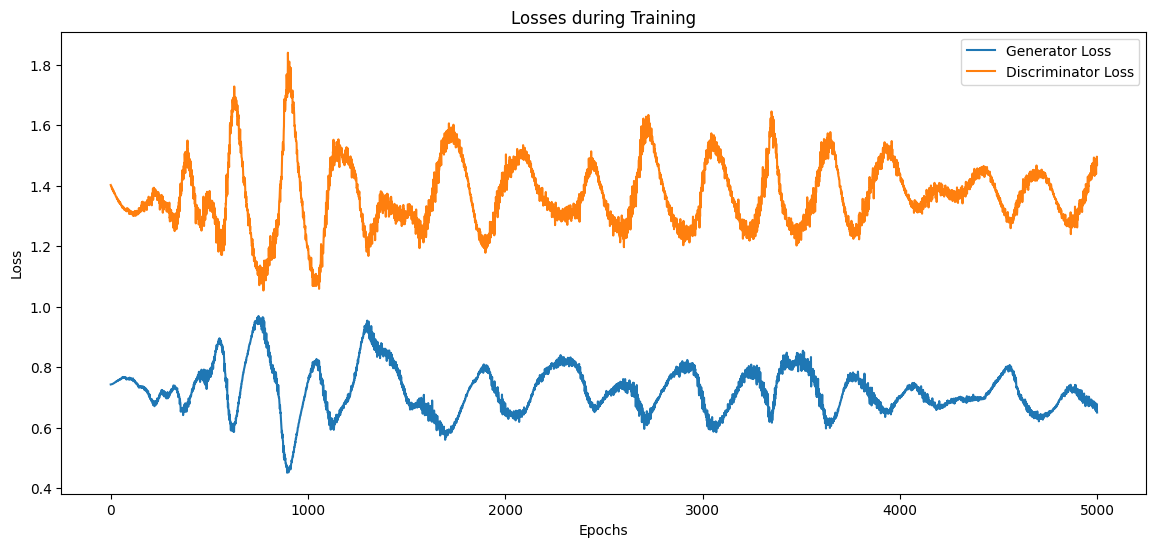

In [124]:
plot_losses(g_losses, d_losses)

### Generate Synthetic Data

In [29]:
def generate_synthetic_data(generator, latent_dim, num_samples):
    # Generate synthetic data
    z = torch.randn(num_samples, latent_dim).to(device)
    synthetic_scaled = generator(z).detach().cpu().numpy()
    synthetic_original = scaler.inverse_transform(synthetic_scaled)
    # Round all columns to integers
    # synthetic_original = np.round(synthetic_original).astype(int)
    # Convert to DataFrame
    synthetic_df = pd.DataFrame(synthetic_original, columns=['Year', 'PROVINCE', 'Week_no', 'Count'])

    # Map back the encoded province names
    synthetic_df['PROVINCE'] = synthetic_df['PROVINCE'].apply(lambda x: province_code_mapping.get(int(x), 'Unknown'))
    
    return synthetic_df

In [126]:
synthetic_df = generate_synthetic_data(generator, latent_dim, 20)
print(synthetic_df.head(20))

    Year                  PROVINCE  Week_no  Count
0   2018                Chaiyaphum       32      3
1   2022              Pathum Thani       47      0
2   2021                   Phichit       46      1
3   2017  Phra Nakhon Si Ayutthaya       45      0
4   2015                   Chainat       17      1
5   2015                   Lopburi       38      2
6   2013              Chachoengsao       22      0
7   2022             Nakhon Phanom       42      1
8   2015                   Kalasin       37      3
9   2017                 Bueng Kan       24     11
10  2023                     Surin       52      0
11  2022                 Khon Kaen       36      5
12  2021              Chachoengsao       29     14
13  2021                 Ang Thong       23      1
14  2020                  Mukdahan       34     24
15  2016                Chiang Mai       24      7
16  2018               Prachinburi       46      1
17  2021                       Nan       33      5
18  2015              Chachoeng

In [105]:
# Save synthetic data to CSV
synthetic_df.to_csv('synthetic_dengue_data.csv', index=False, header=True)

### Visualize the Real vs. Generated

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_real_generated(df, synthetic_df):
    # Histogram Comparison
    plt.figure(figsize=(10, 5))
    sns.histplot(df['Count'], label='Real', color='blue', kde=True, stat='density')
    sns.histplot(synthetic_df['Count'], label='Generated', color='orange', kde=True, stat='density', alpha=0.7)
    plt.title("Distribution of Real vs Generated 'Count'")
    plt.xlabel("Count")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Optional: Line plot of Count over Week (just to see general patterns)
    plt.figure(figsize=(12, 4))
    plt.plot(df['Week_no'][:52], df['Count'][:52], label='Real', marker='o')
    plt.plot(synthetic_df['Week_no'][:52], synthetic_df['Count'][:52], label='Generated', marker='x')
    plt.title("Weekly 'Count' Trend (First 52 Weeks)")
    plt.xlabel("Week_no")
    plt.ylabel("Count")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


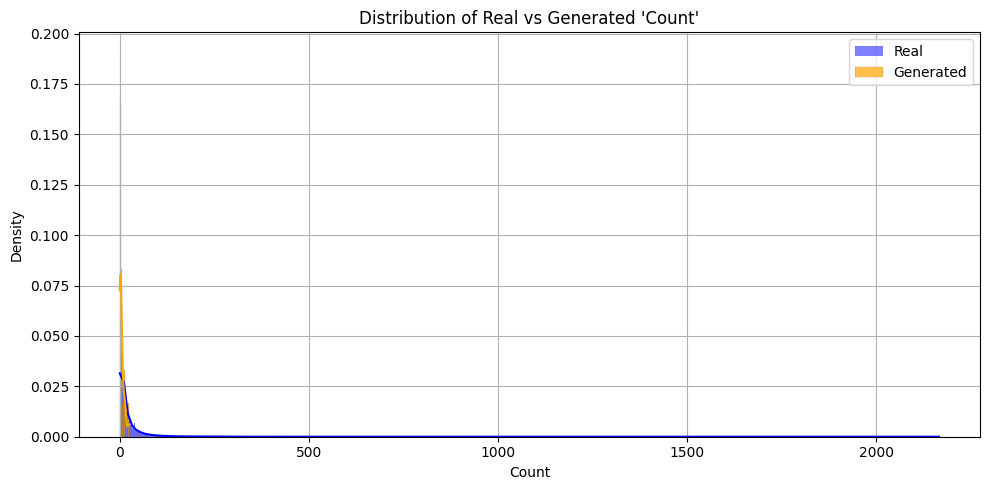

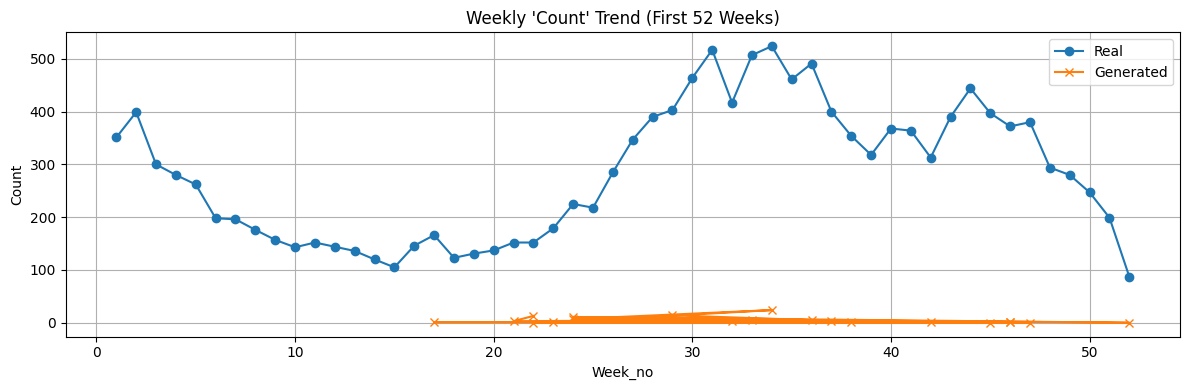

In [129]:
plot_real_generated(df, synthetic_df)

## ⚠️ Why GAN Losses Fluctuate
- The discriminator gets too good, making it hard for the generator to learn.
- The generator collapses (mode collapse): it finds a few "easy" outputs that fool the discriminator.
- Learning rates or model complexity is not balanced.
- GANs are minimax games, so they're inherently unstable.

## ✅ Ways to Improve GAN Stability and Learning
### 1. Use LeakyReLU instead of ReLU
ReLU can "die" (output zero) if gradients are low. LeakyReLU keeps small gradients flowing.

### 2. Add Batch Normalization in the Generator
This helps stabilize learning and smooth out the distribution of hidden layer outputs.

Don't use BatchNorm in the Discriminator — it may help the generator too much.

In [11]:
# Generator
class Generator2(nn.Module):
    def __init__(self):
        super(Generator2, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, data_dim),
            nn.Sigmoid()  # constrain to [0, 1] for MinMax-scaled data
        )

    def forward(self, z):
        return self.model(z)

In [12]:
# Discriminator
class Discriminator2(nn.Module):
    def __init__(self):
        super(Discriminator2, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(data_dim, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [111]:
# Initialize models
generator2 = Generator2().to(device)
discriminator2 = Discriminator2().to(device)

### 3. Use Label Smoothing for Real Samples
Instead of labeling real samples as 1.0, use 0.9 (called soft labeling). This prevents the discriminator from becoming overconfident.

In [112]:
real_labels = torch.full((batch_size, 1), 0.9).to(device)

### 4. Use Smaller Learning Rate for Discriminator
You want to train the discriminator slower than the generator so the generator can catch up.

In [113]:
optimizer_G2 = torch.optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D2 = torch.optim.Adam(discriminator.parameters(), lr=0.0001)

In [114]:
# Train the network
g_losses2, d_losses2 = train_network(data, generator2, discriminator2, optimizer_G2, optimizer_D2, criterion, epochs)

Epoch 0 | D Loss: 1.3387 | G Loss: 0.7703
Epoch 20 | D Loss: 1.3423 | G Loss: 0.7700
Epoch 40 | D Loss: 1.3371 | G Loss: 0.7701
Epoch 60 | D Loss: 1.3385 | G Loss: 0.7700
Epoch 80 | D Loss: 1.3395 | G Loss: 0.7697
Epoch 100 | D Loss: 1.3419 | G Loss: 0.7699
Epoch 120 | D Loss: 1.3417 | G Loss: 0.7700
Epoch 140 | D Loss: 1.3386 | G Loss: 0.7702
Epoch 160 | D Loss: 1.3393 | G Loss: 0.7697
Epoch 180 | D Loss: 1.3386 | G Loss: 0.7699
Epoch 200 | D Loss: 1.3411 | G Loss: 0.7703
Epoch 220 | D Loss: 1.3414 | G Loss: 0.7703
Epoch 240 | D Loss: 1.3409 | G Loss: 0.7697
Epoch 260 | D Loss: 1.3412 | G Loss: 0.7695
Epoch 280 | D Loss: 1.3401 | G Loss: 0.7693
Epoch 300 | D Loss: 1.3400 | G Loss: 0.7700
Epoch 320 | D Loss: 1.3434 | G Loss: 0.7702
Epoch 340 | D Loss: 1.3413 | G Loss: 0.7699
Epoch 360 | D Loss: 1.3425 | G Loss: 0.7691
Epoch 380 | D Loss: 1.3398 | G Loss: 0.7694
Epoch 400 | D Loss: 1.3411 | G Loss: 0.7696
Epoch 420 | D Loss: 1.3427 | G Loss: 0.7698
Epoch 440 | D Loss: 1.3375 | G Loss: 0

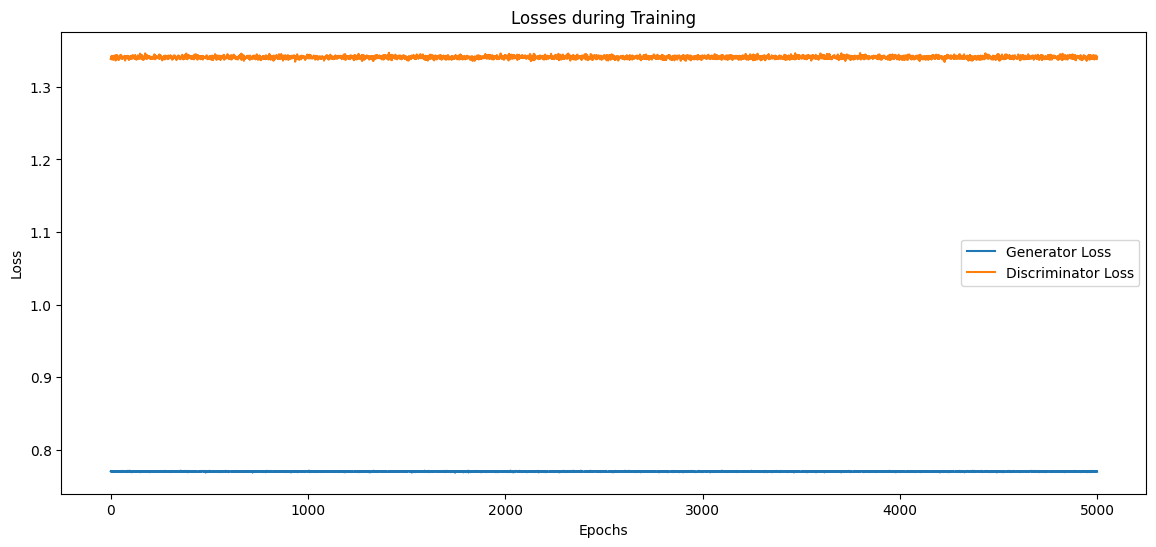

In [125]:
plot_losses(g_losses2, d_losses2)

In [127]:
synthetic_df2 = generate_synthetic_data(generator2, latent_dim, 20)
print(synthetic_df2.head(20))

    Year             PROVINCE  Week_no  Count
0   2019              Pattani       26   1262
1   2019            Phang Nga       25    960
2   2019          Phetchaburi       29   1052
3   2019          Phatthalung       31   1397
4   2019      Nong Bua Lamphu       23   1181
5   2019            Phang Nga       25   1435
6   2019         Pathum Thani       24    902
7   2018           Phetchabun       25   1129
8   2019               Phayao       29   1163
9   2020              Pattani       25   1411
10  2019            Phang Nga       28   1390
11  2019            Phang Nga       26   1166
12  2018           Narathiwat       22   1591
13  2019  Nakhon Si Thammarat       23   1205
14  2018              Pattani       24   1166
15  2019           Nonthaburi       29   1109
16  2020           Nonthaburi       25   1271
17  2019         Pathum Thani       26   1340
18  2019           Phetchabun       30   1243
19  2018          Phatthalung       26   1040


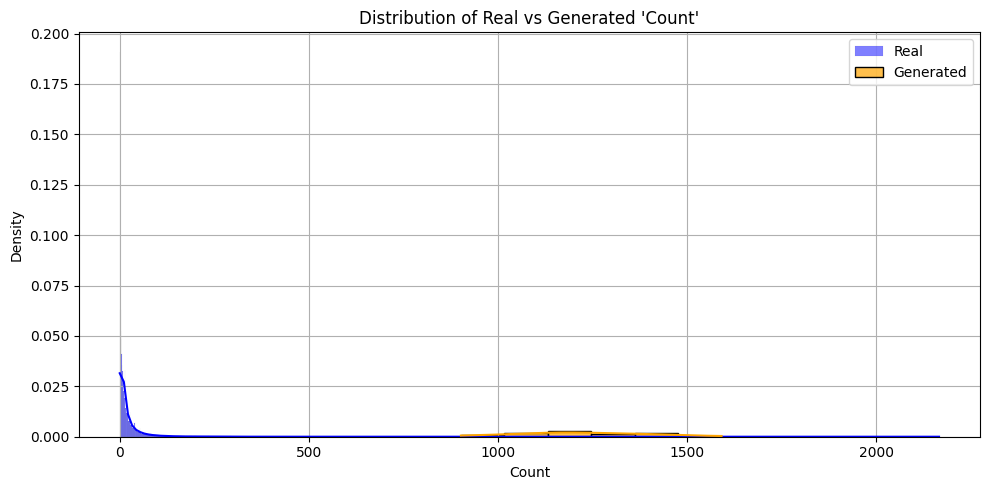

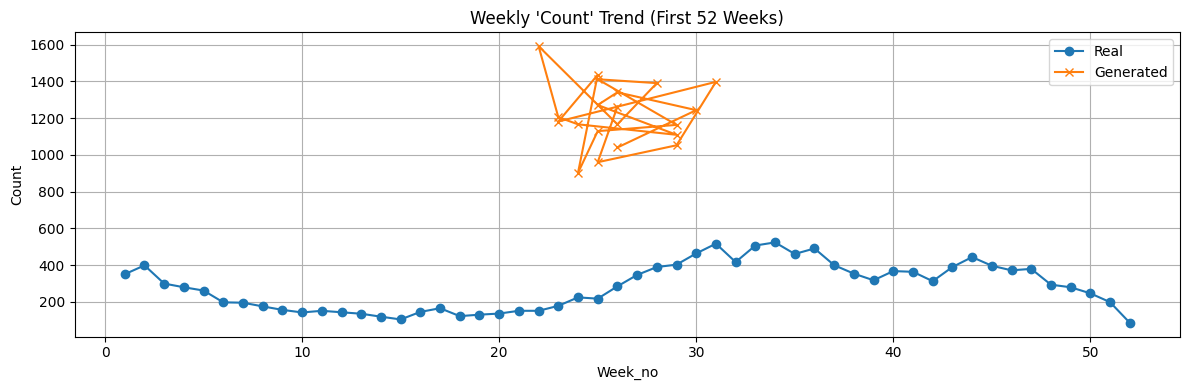

In [130]:
plot_real_generated(df, synthetic_df2)

## Wasserstein GAN with Gradient Penalty
### 🧠 Key Concepts of WGAN-GP
- Replaces discriminator with **critic** that outputs **real-valued scores** (no `Sigmoid`, no `BCELoss`).
- Uses **Wasserstein distance** instead of binary classification loss.
- Enforces **Lipschitz constraint** via a **gradient penalty**, not weight clipping.

In [31]:
print(data[:5])

[[0.         0.02631579 0.         0.16204986]
 [0.         0.02631579 0.01923077 0.18421052]
 [0.         0.02631579 0.03846154 0.13850416]
 [0.         0.02631579 0.05769231 0.12927054]
 [0.         0.02631579 0.07692308 0.1209603 ]]


In [7]:
# Parameters
latent_dim = 10
data_dim = data.shape[1]
batch_size = 64
n_epochs = 5000
n_critic = 5
lambda_gp = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
# Data loader
def get_real_samples(batch_size):
    idx = np.random.randint(0, data.shape[0], batch_size)
    return torch.tensor(data[idx], device=device)


In [10]:
# Critic (no sigmoid)
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(data_dim, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)


In [13]:
# Gradient penalty
def gradient_penalty(critic, real_data, fake_data):
    alpha = torch.rand(real_data.size(0), 1).to(device)
    alpha = alpha.expand_as(real_data)

    interpolates = alpha * real_data + ((1 - alpha) * fake_data)
    interpolates.requires_grad_(True)

    d_interpolates = critic(interpolates)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(gradients.size(0), -1)
    gp = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gp


In [14]:
# Initialize models
generator3 = Generator2().to(device)
critic = Critic().to(device)

In [21]:
# Optimizers
optimizer_G3 = optim.Adam(generator3.parameters(), lr=1e-4, betas=(0.0, 0.9))
optimizer_C = optim.Adam(critic.parameters(), lr=1e-4, betas=(0.0, 0.9))

In [22]:
def train_wasserstein(generator, critic, optimizer_G, optimizer_C, n_epochs, n_critic, latent_dim, batch_size):
    critic_losses = []
    generator_losses = []
    # Training
    for epoch in range(n_epochs):
        for _ in range(n_critic):
            real_samples = get_real_samples(batch_size)
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_samples = generator(z)

            critic_real = critic(real_samples).mean()
            critic_fake = critic(fake_samples).mean()
            gp = gradient_penalty(critic, real_samples, fake_samples)

            loss_C = -critic_real + critic_fake + lambda_gp * gp

            optimizer_C.zero_grad()
            loss_C.backward()
            optimizer_C.step()

        # Generator update
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_samples = generator(z)
        loss_G = -critic(fake_samples).mean()

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

        critic_losses.append(loss_C.item())
        generator_losses.append(loss_G.item())

        if epoch % 100 == 0:
            print(f"[Epoch {epoch}] Critic Loss: {loss_C.item():.4f} | Generator Loss: {loss_G.item():.4f}")
    
    return critic_losses, generator_losses


In [23]:
critic_losses, generator_losses = train_wasserstein(generator3, critic, optimizer_G3, optimizer_C, n_epochs, n_critic, latent_dim, batch_size)

[Epoch 0] Critic Loss: 7.9940 | Generator Loss: 0.1035
[Epoch 100] Critic Loss: -0.4529 | Generator Loss: 0.1993
[Epoch 200] Critic Loss: -0.4583 | Generator Loss: 0.0954
[Epoch 300] Critic Loss: -0.3488 | Generator Loss: 0.0920
[Epoch 400] Critic Loss: -0.3073 | Generator Loss: 0.0696
[Epoch 500] Critic Loss: -0.2210 | Generator Loss: -0.0394
[Epoch 600] Critic Loss: -0.1803 | Generator Loss: -0.0798
[Epoch 700] Critic Loss: -0.1354 | Generator Loss: -0.1655
[Epoch 800] Critic Loss: -0.1103 | Generator Loss: -0.2715
[Epoch 900] Critic Loss: -0.0832 | Generator Loss: -0.3245
[Epoch 1000] Critic Loss: -0.0597 | Generator Loss: -0.3236
[Epoch 1100] Critic Loss: -0.0379 | Generator Loss: -0.3144
[Epoch 1200] Critic Loss: -0.0266 | Generator Loss: -0.2976
[Epoch 1300] Critic Loss: -0.0173 | Generator Loss: -0.2838
[Epoch 1400] Critic Loss: -0.0164 | Generator Loss: -0.3247
[Epoch 1500] Critic Loss: -0.0049 | Generator Loss: -0.3186
[Epoch 1600] Critic Loss: -0.0046 | Generator Loss: -0.318

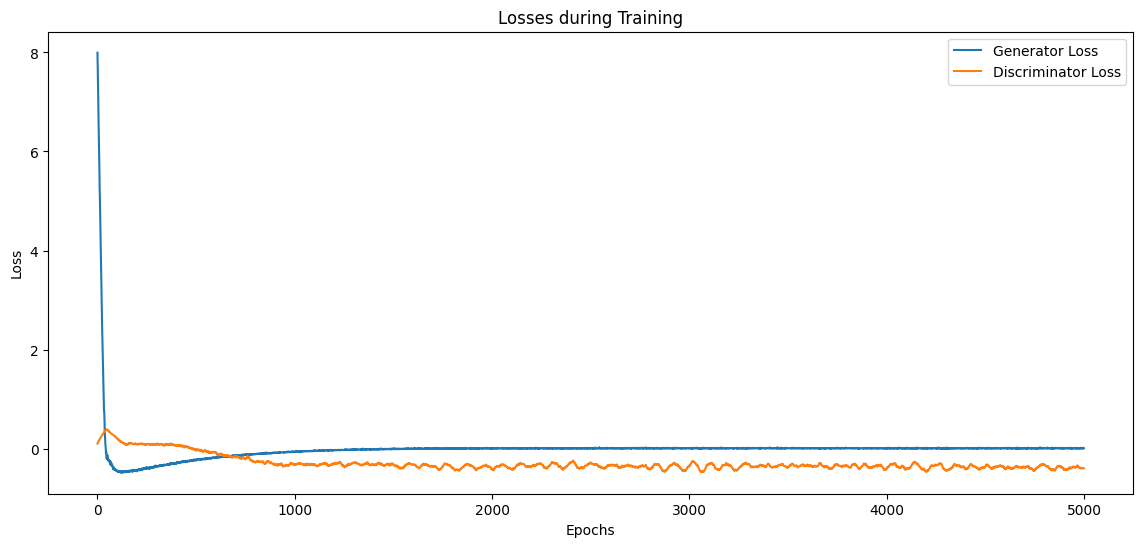

In [26]:
plot_losses(critic_losses, generator_losses)

In [40]:
synthetic_df3 = generate_synthetic_data(generator3, latent_dim, 20)
print(synthetic_df3.head(20))

           Year           PROVINCE    Week_no     Count
0   2014.242554          Sing Buri  38.466400  0.009328
1   2014.619263              Trang  39.411648  0.002018
2   2016.062988         Chaiyaphum  33.936768  0.000168
3   2022.145508       Sakon Nakhon   2.395481  0.000168
4   2013.703613    Samut Songkhram  29.802929  0.001865
5   2018.044922  Nakhon Ratchasima  31.784475  0.010437
6   2014.354004            Pattani   2.797793  0.002344
7   2019.745972      Nakhon Phanom  37.347843  0.005476
8   2016.899414            Lopburi  11.197484  0.002269
9   2018.235962             Phuket  41.025063  0.001205
10  2013.044556            Sisaket   3.221797  0.000007
11  2021.093018              Trang   6.971310  0.002563
12  2014.245728       Chachoengsao  26.844639  0.000939
13  2018.723877                Nan  49.428436  0.000385
14  2019.969727            Lampang  48.722965  0.001979
15  2016.495605              Trang  42.303051  0.002582
16  2017.497437       Samut Sakhon  11.750408  0

In [41]:
# Round the values in the DataFrame to integers
synthetic_df3[['Year', 'Week_no']] = synthetic_df3[['Year', 'Week_no']].round().astype(int)

# For Count, we multiply by 10000 and round to get realistic values
synthetic_df3['Count'] = synthetic_df3['Count'] * 10000
synthetic_df3['Count'] = synthetic_df3['Count'].astype(int)
print(synthetic_df3.head(20))

    Year           PROVINCE  Week_no  Count
0   2014          Sing Buri       38     93
1   2015              Trang       39     20
2   2016         Chaiyaphum       34      1
3   2022       Sakon Nakhon        2      1
4   2014    Samut Songkhram       30     18
5   2018  Nakhon Ratchasima       32    104
6   2014            Pattani        3     23
7   2020      Nakhon Phanom       37     54
8   2017            Lopburi       11     22
9   2018             Phuket       41     12
10  2013            Sisaket        3      0
11  2021              Trang        7     25
12  2014       Chachoengsao       27      9
13  2019                Nan       49      3
14  2020            Lampang       49     19
15  2016              Trang       42     25
16  2017       Samut Sakhon       12     35
17  2016            Chainat        9     10
18  2023      Maha Sarakham       33      3
19  2023       Chachoengsao       32      0


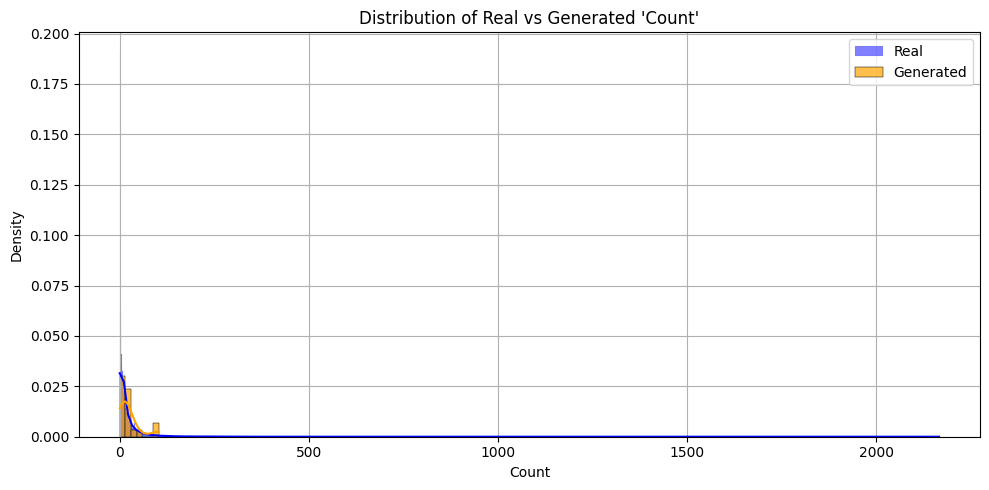

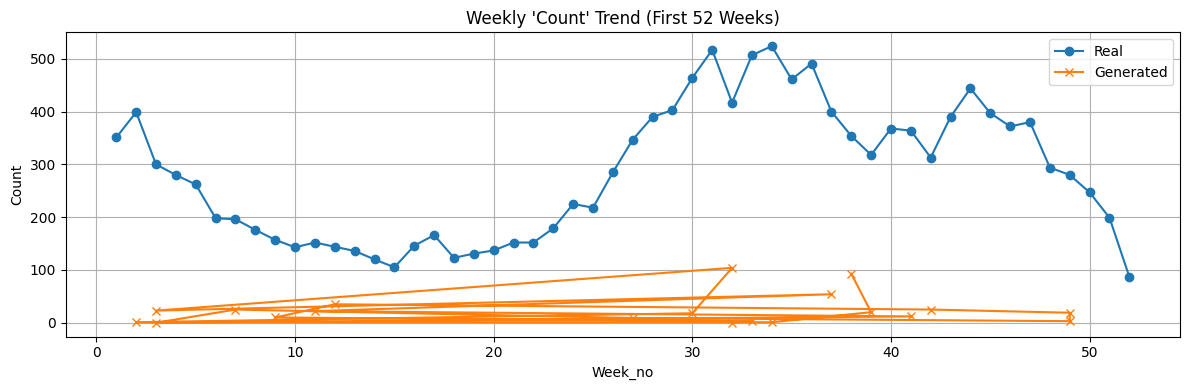

In [42]:
plot_real_generated(df, synthetic_df3)